In [2]:
from sklearn.metrics import plot_roc_curve
import nltk
from nltk.corpus import movie_reviews, stopwords 
from nltk.tokenize import word_tokenize
from nltk.metrics import ConfusionMatrix
from sklearn.metrics import confusion_matrix
import string
import nltk.stem  as stem
import pandas as pd
import numpy as np

In [3]:
documents = []

for category in movie_reviews.categories():
    for file_id in movie_reviews.fileids(category):
        documents.append((movie_reviews.words(file_id), category))

In [4]:
def remove_stop_words_and_stem(review):
    # initialize stopwords list
    stopWords = set(stopwords.words("english"))
    # initialize stemmer
    wordnet_lemmatizer = stem.WordNetLemmatizer()
    # remove punctuation
    no_punctuation = [word.lower() for word in review if word not in string.punctuation]
    # remove stop words
    no_stop_words = [word for word in no_punctuation if word not in stopWords]
    # stem words
    stemmed = [wordnet_lemmatizer.lemmatize(word) for word in no_stop_words]
    # remove words less than 3 characters long
    final = [word for word in stemmed if len(word)>2]
    return " ".join(f for f in final)


In [5]:
texts = []
labels = []
for pair in documents:
    document = list(pair[0])
    new = remove_stop_words_and_stem(document)
    texts.append(new)
    labels.append(pair[1])
labels = np.array(labels)

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(texts)
Y_train = labels
multinomial_nb = MultinomialNB()
multinomial_nb.fit(X_train, Y_train)


MultinomialNB()

In [7]:
print(multinomial_nb.score(X_train, Y_train))

0.9595


In [8]:
def predict_sentiment_NB(text):
    tokens = word_tokenize(text)
    processed = remove_stop_words_and_stem(tokens)
    vectorized_data = vectorizer.transform([processed])
    return multinomial_nb.predict(vectorized_data)[0]

In [9]:
predict_sentiment_NB("Such a great movie")

'pos'

In [10]:
import glob

def load_reviews (dirname):
    negative_path = dirname + '/neg/*.txt'
    negative_file_list = glob.glob(negative_path)
    kind = ["neg"] * len(negative_file_list)
    texts = [str(open(file).read()) for file in negative_file_list]
    positive_path = dirname + '/pos/*.txt'
    positive_file_list = glob.glob(positive_path)
    kind2 = ["pos"] * len(positive_file_list)
    kind.extend(kind2)
    text2 = [str(open(file).read()) for file in positive_file_list]
    texts.extend(text2)
    filename = negative_file_list + positive_file_list
    filename = [x.split("/")[-1:][0] for x in filename]
    df = pd.DataFrame(list(zip(filename,kind,texts)), columns = ['filename', 'kind', 'text'])
    return df

In [11]:
import os

dataset = load_reviews((str(os.getcwd()) + '/small/test'))

In [12]:
dataset

,filename,kind,text
0,472_4.txt,neg,Man with the Screaming Brain is a story of gre...
1,492_1.txt,neg,Well........how and where do I start to descri...
2,218_3.txt,neg,Unbelievably disappointed. The pace was slow. ...
3,307_1.txt,neg,I checked this out at the Vancouver Internatio...
4,342_1.txt,neg,I was excited about this movie after reading o...
...,...,...,...
995,480_10.txt,pos,"If you're tired by the same repetitive, uninte..."
996,122_8.txt,pos,"Overall, a well done movie. There were the par..."
997,194_7.txt,pos,"It's not difficult, after watching this film, ..."
998,70_8.txt,pos,"This movie is certainly well-constructed, begi..."


In [13]:
X = list(dataset.text)
X = [remove_stop_words_and_stem(word_tokenize(x)) for x in X]
Y_test = dataset.kind.to_numpy()
X_test= vectorizer.transform(X)

In [14]:
print(multinomial_nb.score(X_test,Y_test))

0.808


In [15]:
%%timeit
for x in list(dataset['text'])[:1000] :
    predict_sentiment_NB(x)

3.61 s ± 23.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
predictions = multinomial_nb.predict(X_test)
confusion_matrix(Y_test, predictions)

array([[425,  75],
       [117, 383]])

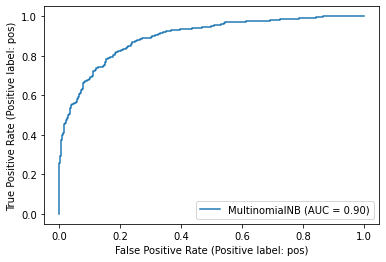

In [65]:
plot_roc_curve(multinomial_nb, X_test, Y_test)

In [84]:
print('Result for a negative:', predict_sentiment_NB("This is a bad movie. The worst I even seen."))
print('Result for a positive:', predict_sentiment_NB("Best movie ever. Wonderful. Love it."))

Result for a negative: neg
Result for a positive: pos


In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression()

In [19]:
print(logreg.score(X_train, Y_train))

0.9735


In [20]:
print(logreg.score(X_test, Y_test))

0.829


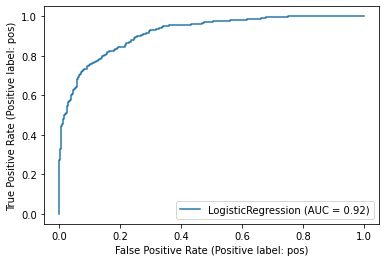

In [66]:
plot_roc_curve(logreg, X_test, Y_test)

Text(0.5, 0.98, 'ROC curve comparison')

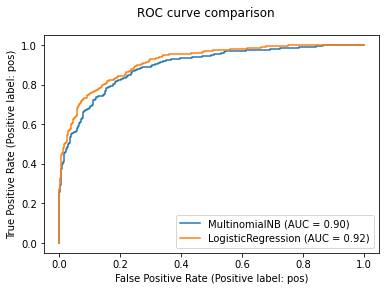

In [68]:
fig = plot_roc_curve(multinomial_nb, X_test, Y_test)
fig = plot_roc_curve(logreg,X_test, Y_test, ax = fig.ax_)
fig.figure_.suptitle("ROC curve comparison")

In [21]:
def predict_sentiment(text):
    tokens = word_tokenize(text)
    processed = remove_stop_words_and_stem(tokens)
    vectorized_data = vectorizer.transform([processed])
    return logreg.predict(vectorized_data)[0]

In [22]:
print('Result for a negative:', predict_sentiment("This is a bad movie. The worst I even seen."))
print('Result for a positive:', predict_sentiment("Best movie ever. Wonderful. Love it."))

Result for a negative: neg
Result for a positive: pos


In [23]:
print(predict_sentiment("Such a great movie"))

pos


In [24]:
print(predict_sentiment("Such an awful movie"))

neg


In [25]:
%%timeit
for x in list(dataset['text'])[:1000] :
    predict_sentiment(x)

3.51 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
predictions = logreg.predict(X_test)
confusion_matrix(Y_test, predictions)

array([[417,  83],
       [ 88, 412]])

In [29]:
import time
start = time.time()
import sentiment_predict as student
medium = time.time()
print("Import:", medium - start)

Import: 8.702278137207031e-05
